In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman',size=10)
import torch.nn as nn
import torch
import random
import torchtext
import torch.optim as optim
import tqdm
import datasets
import functools
import transformers
SEED=0

#通过设置随机种子使得每次的实验结果相同，固定产生随机数据
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
train_data,test_data=datasets.load_dataset('imdb',split=['train','test'])

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
transformer_name='bert-base-uncased'
#加载预训练模型
tokenizer=transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer.tokenize("hello world!")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

['hello', 'world', '!']

In [4]:
#分词器的编码功能
tokenizer.encode('hello world')

[101, 7592, 2088, 102]

In [5]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("hello world"))

['[CLS]', 'hello', 'world', '[SEP]']

In [6]:
tokenizer('hello world')

{'input_ids': [101, 7592, 2088, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [7]:
#使用map的方法将函数应用到dataset类的每个实例中
def tokenize_example(example,tokenizer):
    ids=tokenizer(example['text'],truncation=True)['input_ids']
    return {'ids':ids}

max_length = 256
train_data = train_data.map(tokenize_example, fn_kwargs={'tokenizer': tokenizer})
valid_data = test_data.map(tokenize_example, fn_kwargs={'tokenizer': tokenizer})

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [8]:
#使用dataset对象中的train_test_split方法进行分割，具体的使用方法如下：
test_size=0.25
train_valid_data=train_data.train_test_split(test_size=test_size)
train_data=train_valid_data['train']
test_data=train_valid_data['test']

In [9]:
#将其转化为tensor的形式
train_data=train_data.with_format(type='torch',columns=['ids','label'])
valid_data=valid_data.with_format(type='torch',columns=['ids','label'])
test_data=test_data.with_format(type='torch',columns=['ids','label'])

In [10]:
#加载预训练模型
transformer=transformers.AutoModel.from_pretrained(transformer_name)
transformer.config.hidden_size

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768

In [11]:
pad_index = tokenizer.pad_token_id
pad_index

0

In [12]:
#创建迭代器
def collate(batch,pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [24]:
batch_size=16
collate=functools.partial(collate,pad_index=pad_index)
# merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style dataset.
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [14]:
class Transformer(nn.Module):
    def __init__(self,transformer,output_dim,freeze):
        super().__init__()
        self.transformer=transformer
        self.hidden_dim=transformer.config.hidden_size
        self.fc=nn.Linear(self.hidden_dim,output_dim)

        #设置是否更新梯度
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad=False
    def forward(self,ids):
        #ids=[batch_size,seq_len]
        output=self.transformer(ids,output_attentions=True)
        #注意参数的设置！！！
        hidden=output.last_hidden_state
        attention=output.attentions[-1]
        #attention=[batch_size,n_heads,seq_len,seq_len]
        cls_hidden=hidden[:,0,:]
        #使用tanh作为activation function
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [15]:
out_dim=len(train_data['label'].unique())
out_dim

2

In [16]:
#设置参数
OUTPUT_DIM=2
FREEZE=False
model=Transformer(transformer=transformer,output_dim=OUTPUT_DIM,freeze=FREEZE)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,483,778 trainable parameters


In [18]:
optimizer=optim.Adam(model.parameters(),lr=1e-5)
lossfunction=nn.CrossEntropyLoss()
model=model.to(device)
lossfunction=lossfunction.to(device)

In [22]:
#计算accuracy
def binary_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy
import sys
def train(model,iterator,optimizer,lossfunction):
    epoch_loss=[]
    epoch_acc=[]
    model.train()
    count=0
    for batch in tqdm.tqdm(iterator,desc='training....',file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()
        prediction=model(ids)
        loss=lossfunction(prediction,label)
        acc=binary_accuracy(prediction,label)
        loss.backward()
        optimizer.step()
        if(count%10==0):
            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())

    return epoch_loss , epoch_acc

In [20]:
def eval(model,iterator,lossfunction):
    epoch_loss=[]
    epoch_acc=[]
    model.eval()
    with torch.no_grad():
        count=0
        for batch in tqdm.tqdm(iterator,desc='evaluating....',file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)

            optimizer.zero_grad()
            prediction=model(ids)
            loss=lossfunction(prediction,label)
            acc=binary_accuracy(prediction,label)
            count=count+1
            if(count%10==0):
                epoch_loss.append(loss.item())
                epoch_acc.append(acc.item())
    return epoch_loss , epoch_acc

In [26]:
n_epochs = 1
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(iterator=train_dataloader, model=model, lossfunction=lossfunction, optimizer=optimizer)
    valid_loss, valid_acc = eval(iterator=valid_dataloader, model=model, lossfunction=lossfunction)

    train_losses=train_losses+train_loss
    train_accs=train_accs+train_acc
    valid_losses=valid_losses+valid_loss
    valid_accs=valid_accs+valid_acc

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), r'D:\Python\Python_Project\Python LSTM\Sentiment Analysis （LSTM　CNN　RNN）\simple_transformer.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating....: 100%|██████████| 1563/1563 [07:16<00:00,  3.58it/s]
epoch: 1
train_loss: 0.163, train_acc: 0.938
valid_loss: 0.161, valid_acc: 0.935


In [27]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)['input_ids']
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability


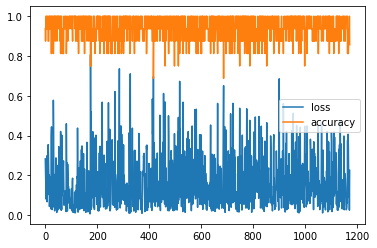

In [36]:
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman',size=10)
df = pd.DataFrame(train_losses, columns=['loss'])
df2=pd.DataFrame(train_accs,columns=['accuracy'])
plt.plot(range(len(train_losses)),df['loss'])
plt.plot(range(len(train_accs)),df2['accuracy'])
plt.legend(['loss','accuracy'])

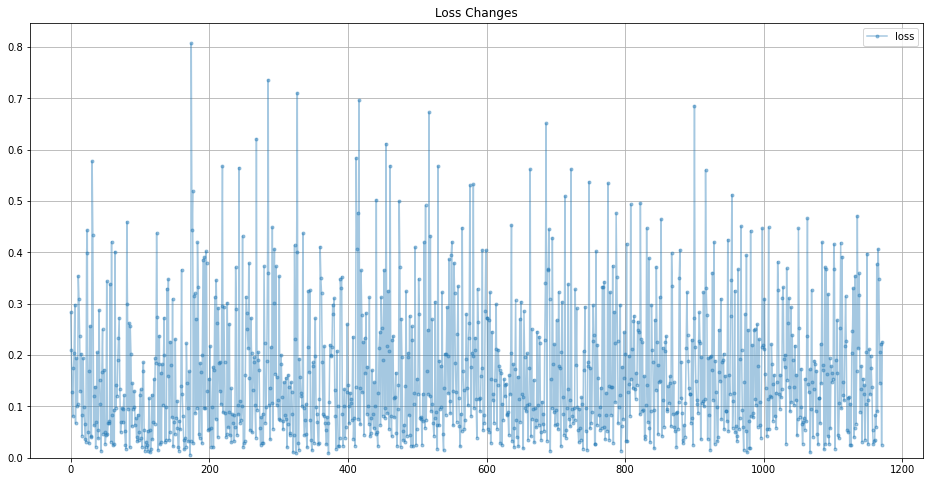

In [35]:
def plot_progress(progress):
        df = pd.DataFrame(progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.4, marker='.', grid=True)
        plt.title('Loss Changes')
plot_progress(train_losses)

In [34]:
model.load_state_dict(torch.load('./D:\Python\Python_Project\Python LSTM\Sentiment Analysis （LSTM　CNN　RNN）\simple_transformer.pt'))

test_loss, test_acc = eval(iterator=test_dataloader, model=model, lossfunction=lossfunction)
epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating....: 100%|██████████| 391/391 [01:50<00:00,  3.54it/s]
test_loss: 0.203, test_acc: 0.925
